In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import pickle
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer

In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use',' court', 'home',' council', 'hunter', 'help', 'time', 'injure', 'national', 'build', 'end', 'bid', 'cup', 'un', 'come', 'security', 'volunteer', 'ship', 'crew', 'crowd', 'join', 'helicopter', 'across', 'museum', 'Italy', 'grind', 'asian', 'sa', 'miss', 'one', 'die', 'use', 'three', 'Darwin', 'vic', 'number', 'may', 'start', 'law', 'way', 'communities', 'order', 'check', 'major', 'India', 'focus', 'form', 'journalist', 'milk', 'nz', 'rank', 'cook', 'egypt', 'New', 'year', 'force', 'fail', 'dead', 'was', 'farmer', 'fruit', 'Philippines', 'injury', 'nick'])
stop_words.extend(['Fire', 'new', 'Hobart', 'rural', 'world', 'boat', 'turn', 'flight', 'around', 'well', 'Find', 'two', 'Adelaide', 'murder', 'first', 'make', 'body', 'probe', 'outback', 'tourism', 'baby', 'David', 'street', 'mass', 'hotel', 'Police', 'say', 'open', 'dog', 'go', 'welcome', 'president', 'announce', 'level', 'allow', 'highest','Queensland', 'kill', 'crash', 'road', 'record', 'nt', 'hit', 'plane', 'toll', 'suspend', 'peninsula', 'afghan', 'recovery','Man', 'Perth', 'flood', 'people', 'prison', 'still', 'supply', 'siege', 'spark', 'summer', 'Michael', 'ops', 'large', 'flash', 'view', 'Attack', 'back', 'mine', 'deal', 'fan', 'celebrate', 'target', 'hill', 'party', 'reveal', 'terrorism', 'video', 'pressure', 'remember', 'Korea', 'Indian', 'millions', 'drill', 'Country', 'hour', 'podcast', 'leaders', 'Thursday', 'abbott', 'Tony', 'policy', 'agricultural', 'shorten', 'sach', 'Day', 'years', 'show', 'teen', 'heat', 'sport', 'issue', 'free', 'Australias', 'asbestos', 'compete','South', 'china', 'talk', 'appeal', 'labor', 'plant', 'Peter', 'allegedly', 'begin', 'try', 'ice', 'native', 'alcohol', 'Australia', 'league', 'live', 'launch', 'campaign', 'benefit', 'update', 'stream', 'cabinet', 'document', 'bob','Test', 'drug', 'Brisbane', 'international', 'British', 'double', 'treat', 'patient', 'ebola', 'Wa', 'bushfire', 'research', 'expansion', 'ready', 'old', 'release', 'paper', 'see'])



In [3]:
import pandas as pd
data = pd.read_csv('/Users/moon-il/Downloads/abcnews-date-text.csv', error_bad_lines=False);

In [4]:
data['publish_date'] = pd.to_datetime(data['publish_date'].astype(str), format = '%Y%m%d')

In [5]:
data['publish_date'] = pd.DatetimeIndex(data['publish_date']).year

In [23]:
data2 = data['headline_text']

data2

0          aba decides against community broadcasting lic...
1             act fire witnesses must be aware of defamation
2             a g calls for infrastructure protection summit
3                   air nz staff in aust strike for pay rise
4              air nz strike to affect australian travellers
5                          ambitious olsson wins triple jump
6                 antic delighted with record breaking barca
7          aussie qualifier stosur wastes four memphis match
8               aust addresses un security council over iraq
9                 australia is locked into war timetable opp
10         australia to contribute 10 million in aid to iraq
11         barca take record as robson celebrates birthda...
12                                bathhouse plans move ahead
13             big hopes for launceston cycling championship
14                    big plan to boost paroo water supplies
15                    blizzard buries united states in bills
16            brigadier 

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data['headline_text']))

In [8]:

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
data_words_nostops = pd.Series(data_words_nostops)
data_lemmatized = data_words_nostops.apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='v') for word in x])

In [10]:
temp = data
temp['lemmatize'] = data_lemmatized
for i in range(15):
    globals()['trend{}'.format(i+2003)] = temp.loc[temp.publish_date == i+2003]

In [11]:
trend_list = [trend2003, trend2004, trend2005, trend2006, trend2007, trend2008, trend2009, trend2010, trend2011, trend2012, trend2013, trend2014, trend2015, trend2016, trend2017]

In [12]:
lemmatized = list(trend2015['lemmatize'])
id2word = corpora.Dictionary(lemmatized)
texts = lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -28.303337413137122

Coherence Score:  0.4532904782267848


In [15]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.306*"say" + 0.249*"south" + 0.085*"tas" + 0.034*"mick" + 0.029*"turn" + '
  '0.000*"december" + 0.000*"west" + 0.000*"coast" + 0.000*"sydney" + '
  '0.000*"sea"'),
 (1,
  '0.182*"call" + 0.178*"queensland" + 0.136*"melbourne" + 0.123*"perth" + '
  '0.039*"thousands" + 0.028*"alert" + 0.027*"reveal" + 0.026*"spark" + '
  '0.020*"amid" + 0.017*"illegal"'),
 (2,
  '0.318*"country" + 0.210*"nsw" + 0.134*"qld" + 0.033*"thursday" + '
  '0.030*"laws" + 0.026*"suspend" + 0.000*"december" + 0.000*"november" + '
  '0.000*"christmas" + 0.000*"north"'),
 (3,
  '0.238*"hobart" + 0.161*"council" + 0.122*"die" + 0.120*"miss" + 0.028*"mt" '
  '+ 0.021*"conviction" + 0.016*"event" + 0.000*"sydney" + 0.000*"yacht" + '
  '0.000*"race"'),
 (4,
  '0.320*"adelaide" + 0.114*"show" + 0.033*"fee" + 0.000*"strikers" + '
  '0.000*"footage" + 0.000*"big" + 0.000*"bash" + 0.000*"christmas" + '
  '0.000*"sydney" + 0.000*"drone"'),
 (5,
  '0.057*"agriculture" + 0.024*"rank" + 0.015*"body" + 0.000*"investme

In [16]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.266078  0.253849       1        1  10.924344
6      0.144923 -0.243828       2        1   9.745586
16     0.112896 -0.105104       3        1   9.550039
2      0.081745 -0.051741       4        1   8.956974
0     -0.010331  0.006369       5        1   7.963267
7      0.079934 -0.049576       6        1   7.775337
19     0.027917 -0.009414       7        1   7.079559
18    -0.032466  0.012692       8        1   6.738974
3     -0.007433  0.005425       9        1   5.351706
11    -0.052874  0.017111      10        1   4.944031
12    -0.046420  0.015860      11        1   4.878717
9     -0.018490  0.008888      12        1   3.689659
14    -0.070922  0.018564      13        1   2.423277
13    -0.069441  0.019002      14        1   2.391417
4     -0.070528  0.018825      15        1   2.293167
15    -0.070896  0.018386      16        1   1.774452
8     -0.070728  0.018752      17        1   1.696308
17    -0.069066  0.017154      18        1   1.011918
5     -0.063314  0.014883      19        1   0.563065
10    -0.060584  0.013903      20        1   0.248202, topic_info=      Category          Freq         Term         Total  loglift  logprob
term                                                                     
181    Default  13957.000000          man  13957.000000  30.0000  30.0000
87     Default  12798.000000       police  12798.000000  29.0000  29.0000
38     Default  12237.000000    australia  12237.000000  28.0000  28.0000
218    Default  12224.000000      country  12224.000000  27.0000  27.0000
65     Default   8756.000000         fire   8756.000000  26.0000  26.0000
18     Default  10441.000000          say  10441.000000  25.0000  25.0000
273    Default  10901.000000           wa  10901.000000  24.0000  24.0000
71     Default   7562.000000         find   7562.000000  23.0000  23.0000
36     Default   8688.000000          day   8688.000000  22.0000  22.0000
95     Default   8492.000000        south   8492.000000  21.0000  21.0000
135    Default   9039.000000   australian   9039.000000  20.0000  20.0000
220    Default   8068.000000          nsw   8068.000000  19.0000  19.0000
196    Default   8530.000000         call   8530.000000  18.0000  18.0000
263    Default   8354.000000   queensland   8354.000000  17.0000  17.0000
123    Default   5459.000000       hobart   5459.000000  16.0000  16.0000
113    Default   5776.000000        court   5776.000000  15.0000  15.0000
250    Default   5842.000000         test   5842.000000  14.0000  14.0000
78     Default   4857.000000       attack   4857.000000  13.0000  13.0000
199    Default   6396.000000    melbourne   6396.000000  12.0000  12.0000
186    Default   5747.000000        perth   5747.000000  11.0000  11.0000
3      Default   5161.000000          qld   5161.000000  10.0000  10.0000
0      Default   3156.000000     adelaide   3156.000000   9.0000   9.0000
20     Default   4845.000000         take   4845.000000   8.0000   8.0000
40     Default   3699.000000      council   3699.000000   7.0000   7.0000
240    Default   3569.000000         fall   3569.000000   6.0000   6.0000
274    Default   2820.000000         kill   2820.000000   5.0000   5.0000
45     Default   4329.000000        price   4329.000000   4.0000   4.0000
52     Default   2563.000000        water   2563.000000   3.0000   3.0000
15     Default   4002.000000          box   4002.000000   2.0000   2.0000
16     Default   3660.000000        could   3660.000000   1.0000   1.0000
...        ...           ...          ...           ...      ...      ...
29188  Topic20      0.036465      trouser      4.561169   1.1697 -10.2815
9719   Topic20      0.036465   acceptance      4.560874   1.1698 -10.2815
9721   Topic20      0.036465       emwazi      4.560869   1.1698 -10.2815
9722   Topic20      0.036465  executioner      4.560869   1.1698 -10.2815
9723   Topic20      0.036465   

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/moon-il/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [19]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

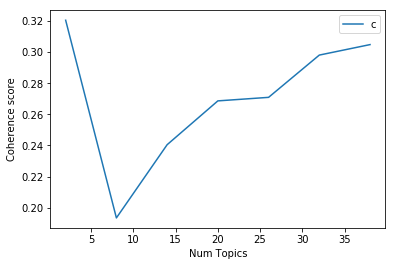

In [20]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))